# 1. Подготовка данных к построению модели
## 1.1 Загрузка библиотек и датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('Albuquerque Home Prices.txt', sep='\t')
df = df.replace(-9999, np.nan)

In [3]:
df.head()

,PRICE,SQFT,AGE,FEATS,NE,CUST,COR,TAX
0,2050,2650,13.0,7,1,1,0,1639.0
1,2080,2600,NaN,4,1,1,0,1088.0
2,2150,2664,6.0,5,1,1,0,1193.0
3,2150,2921,3.0,6,1,1,0,1635.0
4,1999,2580,4.0,4,1,1,0,1732.0


In [4]:
df.apply(lambda x: sum(x.isnull()), axis=0)

PRICE     0
SQFT      0
AGE      49
FEATS     0
NE        0
CUST      0
COR       0
TAX      10
dtype: int64

Таким образом, видим, что источниками пропущенных значений являются колонки ```AGE``` и ```TAX```. Раз в колонке ```AGE``` так много пропусков, то проще её будет убрать из анализа, чем пытаться заделать эти дырки.

In [5]:
del df['AGE']

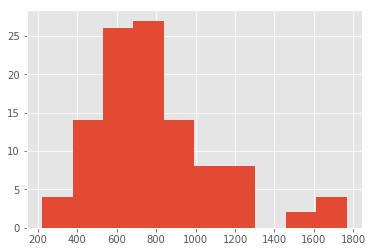

In [6]:
df['TAX'].hist()

Раз распределение похоже на нормальное, то можно заменить пропуски на среднее значение этой колонки. Для этого в pandas есть функция ```Series.fillna```, которая заменяет все пропущенные в колонке значения на заданное.

In [7]:
df['TAX'] = df['TAX'].fillna(df['TAX'].mean())

# 2. Линейные модели
## 2.1 Достоинства и недостатки 

Итак, прежде чем перейти к построению модели линейной регрессии обсудим все теоретические основы.

Также подчеркну, что у линейное модели есть существенный недостатки, но есть и достоиства.

1. Преимущества:
   * Модель сама по себе простая
   * Отсутствуют гиперпараметры, что упрощает сам процесс обучения 
   * Легко интерпритировать коэффициенты(параметры) модели(невсегда)
   * Если действительно существует линейная или близкая к ней зависимость, то такая модель будет лучше, чем более сложные
   * Более эффективна, чем сложные в условиях разреженности и огромного размера данных
2. Недостатки:
   * Само по себе может быть ошибочно предположение о линейности(то есть в случае нелинейности модель неэффективна)
   * Коэффициенты модели могут быть неадекватны(слишком большие), возможное решение - регуляризация 
   * Неустойчива к коллинеарности (L2 - как решение)
   * Невозможность геометрической интерпритации в случае более n-мерного пространства для $n>2$
   


## 2.2 Геометрическая интерпритация 

Итак, рассмотрим задачу в её геометрической интерпритации

Сначала упростим её, чтобы можно было рисовать 2D-картинки 

Попробуем предсказывать цену дома в зависимости только от площади:

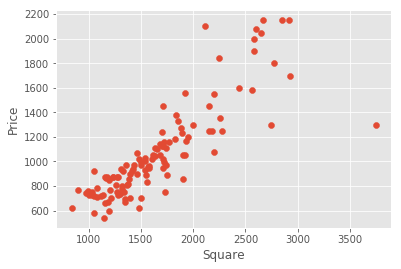

In [8]:
plt.scatter(x='SQFT', y = 'PRICE',data = df)
plt.xlabel('Square')
plt.ylabel('Price')
plt.show()

В принципе картинка выглядит линейно, хоть и присутствуют выбросы, наша цель построить прямую, которая приблизит собой эти точки

Общая постановка задачи для нашего случая:
`x` - площадь дома, `y` - цена дома

Запишем уравнение:
\begin{gather}   
    y = a+bx
\end{gather} , где `a` - свободный член , `b` - коэффициент при слагаемом площади дома

Наша цель подобрать коэффициенты так, чтобы прямая как можно лучше прилегала к точкам

Пусть `a` = 200/3, `b` = 2/3

In [9]:
import numpy as np
x = np.linspace(df['SQFT'].min(),df['SQFT'].max())

In [10]:
y = [(i-100)/1.5 for i in x]

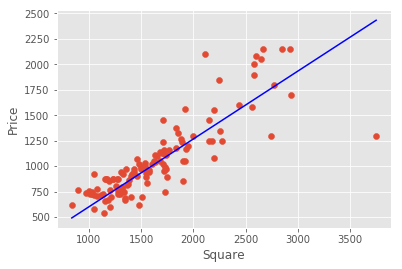

In [11]:
plt.scatter(x='SQFT', y = 'PRICE',data = df)
plt.xlabel('Square')
plt.ylabel('Price')
plt.plot(x, y,color = 'blue')

## 2.3 Теоретические выкладки

Получилось неплохо, но является ли решение данной задачи оптимальным?
Перейдем к теории

Итак, пусть у нас имеется набор данных:

X = $\begin{bmatrix}                        
 x_{11} \ x_{12} \ ... \ x_{1m} \\  
 x_{21} \ x_{22} \ ... \ x_{2m}\\
 ............  \\
 x_{n1} \ x_{n2} \ ... \ x_{nm} \\
  \end{bmatrix}$
  
Y = $\begin{bmatrix}
 y_1 \\
 y_2 \\
 .   \\
 y_n
  \end{bmatrix}$



`X` - матрица размером `nxm`, где `n` - число наблюдений, `m` - число признаков
`y` - столбец с зависимой переменной. 




Итак, будем искать каждый $\mathcal{y}_k$:


$\mathcal{y}_k = a_0+\sum_{i=1}^m \mathcal{a}_i\mathcal{x}_i  $ , где $i=1,2,\dots,m$,  $k=1,2,\dots,n$ , $\vec a$ - вектор коэффициентов, $\vec x$ - вектор признаков

Для удобства возьмем $\mathcal{x}_0 = 1$ и перепишем задачу в более удобной форме:

$\mathcal{y}_k = \sum_{i=1}^m \mathcal{a}_i\mathcal{x}_i $, где $i=0,1,\dots,m$ , $k=1,2,\dots,n$




Пусть $\mathcal{y}_i$ - реальные значения на i-ом образце, а $\hat y_i$ - ответы модели
на i-том образце 


Величину $\mathcal{E}_i =y_i -  \hat y_i  $ называют невязкой или отклонением 


Дальше наша задача минимизировать ошибки, то есть минимизировать функцию:

$\sum_{i=1}^n (y_i -  \hat y_i) \quad $,

В этом случае не учитывается знак ошибки

Пусть на 1 наблюдении ошибка равна $y_1 -  \hat y_1 = 5$, на 2-ом $y_2 -  \hat y_2 = -5$, тогда их сумма дает 0, что неверно.

Есть лекарство:

1. Модуль MAE = $\sum_{i=1}^n |(y_i -  \hat y_i)| \quad $
2. Квадрат  MSE = $\sum_{i=1}^n (y_i -  \hat y_i)^2 \quad $

Какой из них предпочтительней?

Исследователь выбирает для себя сам, учитывать или ему выбросы, то есть сильные отклонения от правильных ответов.

Если нужно учитывать сильное влияние отклонений, то лучше MAE, иначе - MSE.

Но рассмотрим некоторые другие функции потерь
3. Mean Absolute Percentage Error = $\frac{100}{n}\sum_{1}^{n}\frac{|y_i-\hat y_i|}{max(|\hat y|,\varepsilon )}$

Данная метрика измеряет относительную ошибку, то есть призвана решить всю ту же проблему - чрезмерное влияние больших отклонений.

4. Mean Squared Logarithmic Error = $\frac{1}{n}\sum_{1}^{n} (log(y_i+1)-log(\hat y_i+1))^2$

Данная метрика призвана бороться с той же проблемой, но учитывает не относительные ошибки, а разницу логарифмов.

5. logcosh = $ \frac{1}{n}\sum_{1}^{n}log(cosh(y_i - \hat y_i)) $

Данная метрика ведет себя как MAE при больших значения разницы $y_i - \hat y_i $, при малых - как MSE.

Для дальнейшего удобства рассмотрим вариант 2 (MSE), его выбираем из соображения удобства дифференцирования.

Итак, наша задача снизить количество ошибок модели, то есть найти минимум данного выражения.

`X` и `y` мы знаем, осталось найти параметры $\hat a$.

$\sum_{i=1}^n (y_i -  \hat y_i)^2 \rightarrow min $


Параметры $\hat a$ ищутся именно с помощью метода максимального правдоподобия. 

$ \frac{\partial MSE}{\partial \hat a} = 0 $

Найдем производные по каждому параметру и приравняем к 0:


  $\frac{\partial MSE}{\partial  a_1} = -2x_1\sum_{i=1}^{n}(y_i-\sum_{k=1}^{m}a_kx_k) = 0 $
  

  $\frac{\partial MSE}{\partial  a_2} = -2x_2\sum_{i=1}^{n}(y_i-\sum_{k=1}^{m}a_kx_k) = 0 $ 

  $ \vdots $
  
  $ \frac{\partial MSE}{\partial  a_n} = -2x_n\sum_{i=1}^{n}(y_i-\sum_{k=1}^{m}a_kx_k) = 0 $


Решив данную систему уравнений, найдем `a`.


Так же важной теоритической предпосылкой является теорема `Гаусса - Маркова`

[О ней здесь](https://ru.wikipedia.org/wiki/Теорема_Гаусса_—_Маркова)




## 2.4  Построение модели



In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
X = df.drop('PRICE', axis=1)
y = df['PRICE']

In [14]:
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Считаем качество модели (коэффициент $R^2$).
$$
R^2 = 1 - \frac{\sum_{i=1}^n{(y_i-\hat y_i)}}{\sum_{i=1}^n{(y_i-\bar y_с)}} 
$$
$\bar y_с$ - Среднее

In [15]:
print('R^2: {0}'.format(model.score(X, y)))

R^2: 0.8022436103807492


Выведем регрессионные коэффициенты от метода ```model.coef_``` и свободный член от метода ```model.intercept_```.

In [16]:
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
coef

,predictor,coef
0,intercept,83.175919
1,SQFT,0.291978
2,FEATS,12.176743
3,NE,8.011604
4,CUST,133.014342
5,COR,-65.800841
6,TAX,0.541942


Как интерпретировать модель? У нас есть 3 значимых предиктора: ```SQFT```, ```CUST``` и ```TAX```.  Значение коэффициента говорит, на сколько вырастет значение сигнала при увеличении предиктора на одну единицу. Смысл первых двух коэффициентов понятен: площадь и специальный вид постройки ожидаемо влияют на цену. Но есть ли смысл включать в предсказание цены дома налог с этого же дома? Ведь налог, как и цена, также начисляется исходя из похожих предикторов. Они должны сильно коррелировать. И действительно. Построим таблицу парных корреляций предикторов.

In [17]:
df.corr()

,PRICE,SQFT,FEATS,NE,CUST,COR,TAX
PRICE,1.000000,0.844795,0.420272,0.167840,0.555292,-0.079293,0.844889
SQFT,0.844795,1.000000,0.394925,0.145030,0.520102,0.040528,0.832674
FEATS,0.420272,0.394925,1.000000,0.190016,0.241964,-0.041547,0.419473
NE,0.167840,0.145030,0.190016,1.000000,0.043033,-0.077336,0.189230
CUST,0.555292,0.520102,0.241964,0.043033,1.000000,-0.003994,0.444906
COR,-0.079293,0.040528,-0.041547,-0.077336,-0.003994,1.000000,-0.058329
TAX,0.844889,0.832674,0.419473,0.189230,0.444906,-0.058329,1.000000



Налоги сильно коррелируют с площадью. Предлагается откинуть налоги.

Воспользуемся статистическими критериями для интерпритации важности коэффициентов линейной модели.

Будем выдвигать гипотезу о том, что каждый коэффициент равен 0 и будем смотреть на `p-value`.

$H_o : X_i = 0 $

In [18]:
import statsmodels.api as sm
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     74.37
Date:                Wed, 12 Feb 2020   Prob (F-statistic):           2.01e-36
Time:                        16:39:56   Log-Likelihood:                -765.84
No. Observations:                 117   AIC:                             1546.
Df Residuals:                     110   BIC:                             1565.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.1759     63.308      1.314      0.1

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


И действительно, заметим, что `SQFT` и `TAX` имеют `p-value` равным 0, то есть они важны для модели, но скоррелированны, так же важен признак `CUST`



In [19]:
X = df[['TAX', 'CUST','SQFT']]
model.fit(X, y)
print(model.score(X, y))

0.7956603297679673


Заметим, что наша модель стала хуже всего лишь на 7 сотых после отбрасывания незначительных признаков, но мы отобрали главные признаки, а также сэкономили время на построении модели, что в более серьзных задачах может быть решающим фактором.

# 3 Полиномиальные признаки
## 3.1 Подготовка данных

In [20]:
df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])

In [21]:
df.head()

,weight,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


Будем предсказывать цену кольца с бриллиантом от веса бриллианта. Попробуем предсказать результат не только с помощью самой переменной, но и с помощью её степеней. Первая модель будет зависеть только от самой переменной weight, вторая -- от переменной $weight^2$, а третья -- от двух этих переменных сразу.
В этих случаях, когда мы хотим попробовать в качестве фичей их степени и произведения фич, в `sklearn.preprocessing` есть класс `PolynomialFeatures`. Метод `fit_transform` этого класса сгенерирует из данного множества фич множество одночленов заданной степени. Например, для степени 2 и фич a, b будут сгенерированы фичи [a, b, $a^2$, $b^2$, ab], а при указанном параметре `include_bias=True` ещё и вектор-свободный член из единиц. Для данной задачи, конечно, проще было сгенерить один столбец из квадратов значений колонки weight. Но нам важно ознакомиться с классом PolynomialFeatures для дальнейшего применения.

## 3.2 Построение модели 

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price']
X0 = poly.fit_transform(df[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight^2'])
X0.head()

,weight,weight^2
0,0.17,0.0289
1,0.16,0.0256
2,0.17,0.0289
3,0.18,0.0324
4,0.25,0.0625


Составим отдельные модели:
* на основе признака `weight`
* на основе признака $weight^2$
* на основе обоих этих признаков

In [23]:
m = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight^2
    X0[['weight^2']],
    # Две переменных weight и weight^2
    X0.copy()]
models = [LinearRegression() for _ in m]

In [24]:
for X, model in zip(m, models):
    model.fit(X, y)
    print(model.score(X, y))

0.978260777986033
0.970310818417109
0.9789175801893899


Получилось, что $R^2$ во всех моделях примерно одинаков. Однако не все они одинаково полезны

In [25]:

X2 = sm.add_constant(m[2])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1045.
Date:                Wed, 12 Feb 2020   Prob (F-statistic):           1.94e-38
Time:                        16:39:58   Log-Likelihood:                -232.47
No. Observations:                  48   AIC:                             470.9
Df Residuals:                      45   BIC:                             476.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -174.1301     74.238     -2.346      0.0

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Заметим, что признак `weight` оказался не важен для модели, это вызвано высокой скоррелированостью(как бы это не было странно) этого признака с $weight^2$

## 3.3 Полиномиальные признаки в задачах классификации
 ### 3.3.1 Создание игрушечных данных

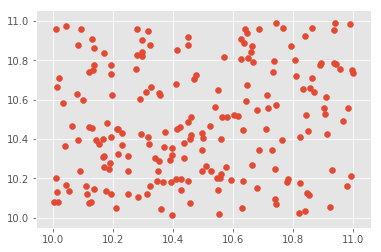

In [26]:
N = 200
x = np.random.rand(N)+10
y = np.random.rand(N) +10

plt.scatter(x, y)
plt.show()

In [27]:
def Feature(row):
    if (row['X']-10.5)**2+(row['Y']-10.5)**2 <=0.7 and (row['X']-10.5)**2+(row['Y']-10.5)**2 >=0.2:
        return 1
    else: 
        return 0

In [28]:
T = pd.DataFrame({'X' : x,
                       'Y' : y})

In [29]:
T['Label'] = T.apply(lambda row: Feature(row),axis = 1)

In [30]:
Ca = T['Label'].map({1: 'green',0: 'orange'})

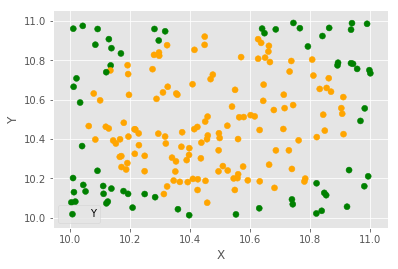

In [31]:
plt.scatter(T['X'],T['Y'], color = Ca)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

Поставим задачу классификации, которая отделит желтые точки от зеленых. Линейной это невозможно, помогут ли полиномиальные признаки?

In [32]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

# каждой точке в сетке [x_min, m_max]x[y_min, y_max]
# ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [33]:
X = T[['X','Y']].values
Y = T[['Label']].values

In [34]:
poly = PolynomialFeatures(degree=60)
X_poly = poly.fit_transform(X)

### 3.3.2 Построение модели классификации с полиномиальными признаками

C:\Users\nozdr\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nozdr\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nozdr\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Доля правильных ответов классификатора на обучающей выборке: 0.875


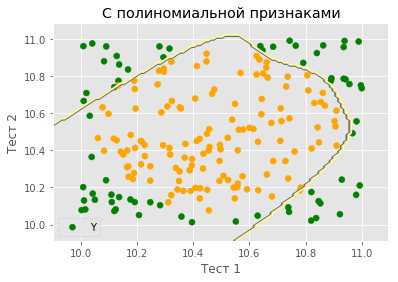

In [35]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
C = 1
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)
logit.fit(X_poly, Y)

plot_boundary(logit, X ,Y, grid_step=.01, poly_featurizer=poly)

plt.scatter(T['X'],T['Y'], color = Ca)
plt.xlabel("Тест 1")
plt.ylabel("Тест 2")
plt.title('C полиномиальной признаками')
plt.legend();

print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, Y), 3))

Модель хоть и неидеально решает задачу, но полиномиальные признаки помогли создать более-менее четкую границу между классами.

# 4.Регуляризация

Итак, вернемся к  пункту 2, в котором мы строили линейную модель.

Мы получили значения весов( вектора $\hat a$), но в некоторых задач они могут стать совершенно неадекватными(быть слишком маленькими или большими)

Это связано с тем, что наша модель переучиывается, в таких ситуациях нам поможет регуляризация.

Рассмотрим 2 вида регуляризации: 
1. Lasso  $L1: \left \| a \right \|_1 = \lambda \sum_{i=1}^{n}|a_i| $
2. Ridge  $L2: \left \| a \right \|_1 = \lambda \sum_{i=1}^{n}a_i^2 $

$\lambda 
\in [0,1] $

$\lambda$ - параметр регуляризации

С помощью этого параметра мы можем ослаблять 

$\lambda$ больше => веса меньше

$\lambda$ меньше => веса больше

Есть ещё и другие виды регуляризации, например, `ElasticNet` - L1+L2

`Lasso` - регуляризация помогает отобрать лучшие признаки для модели, обнуляя самые незначительные.

Как это происходит?

* Рассмотрим геометрическую интерпритацию, связанную со свойствами норм 

<img  src="https://craftappmobile.com/wp-content/uploads/2017/11/1-min.png" alt="center" width="767" height="430">

Если это Вам не помогло, предлагаю проделать все вручную, взяв за основу самую простую модель:

$y$ = $a_1x$

В случае `L1-регурялизации`: $y = a_1x + \lambda a_1$

В случае `L2-регурялизации`: $y = a_1x + \lambda a_1^2$

Найдем оценки параметра $a_1$ в обоих случаях и почувствуем разницу. Искать оценки будем с помощью ММП:

$ \frac{\partial MSE}{\partial \hat a} = 0 $

Для первого случая: MSE = $(y-a_1x)^2+\lambda a_1$

1. Расскроем скобки.

  $y^2 - 2a_1yx+a_1^2x^2+\lambda a_1 $
  
2. Найдем производную.

 $ \frac{\partial MSE}{\partial \hat a_1} = -2yx+2a_1x^2+\lambda $
 
3. Приравняем производную к 0.
 
 $ -2yx+2a_1x^2+\lambda = 0 $

4. Выражаем параметр $a_1$:
   
   $2a_1x^2 = -\lambda+2yx$
   
   $a_1 = \frac{\lambda+yx}{2*x^2}$
   
Заметим, что при определенном выборе $\lambda$, например, в нашем случае можно взять `-yx`, числитель будет равен 0

Соответственнно будет равен и 0 параметр $a_1$

Теперь сделаем все то же самое и для `Ridge` регуляризации.

Для этого случая: MSE = $(y-a_1x)^2+\lambda a_1^2$

1. Расскроем скобки.

  $y^2 - 2a_1yx+a_1^2x^2+\lambda a_1^2 $
  
2. Найдем производную.

 $ \frac{\partial MSE}{\partial \hat a_1} = -2yx+2a_1x^2+2\lambda a_1 $
 
3. Приравняем производную к 0.
 
 $ -2yx+2a_1x^2+2\lambda a_1 = 0 $

4. Выражаем параметр $a_1$, сокращая на 2:
   
   $a_1x^2 + a_1\lambda= yx$
   
   $a_1(x^2+\lambda) = xy$
   
   $a_1 = \frac{xy}{\lambda+x^2}$
   
Заметим, что какое мы не взяли бы $\lambda$, числитель все равно остается неизменным

Только при увелечении $\lambda$ знаменатель дроби будет стремится к бесконечности, а вся дробь и значение $a_1$ к 0.
   


# 5. Непараметрическая регрессия 

Иногда линейная регрессия бессильна против задачи даже с полиномиальными признаки.

Существует много других методов, но мы рассмотрим параметрическую регрессию.

Одним из простейших методов является ядерное сглаживание. Этот метод прост в применении, не требует дополнительных математических сведений и понятен на интуитивном уровне. 

В библиотеке `sklearn` реализованы два типа непараметрической регрессии:

1. [KernelRidge](https://scikit-learn.org/0.21/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge)

2. [Gaussian process regression](https://scikit-learn.org/0.21/auto_examples/gaussian_process/plot_compare_gpr_krr.html#sphx-glr-auto-examples-gaussian-process-plot-compare-gpr-krr-py)

Так же есть целая библитека PyQt_fit, в которой есть много всего.


3. [PyQt-Fit](https://pythonhosted.org/PyQt-Fit/)

Там же можно найти кучу полезной информации по анализу остатков, использующегося для построения модели регрессии, в частности при работе с временными рядами.


